In [241]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [2]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import torch

In [4]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import visualisation
import nms
%load_ext autoreload
%autoreload 2
import map_iou
import zft_nms
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [6]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'CSV': '../data/csv',
}

SIDE = 1024

In [7]:
def non_max_suppression_fast(boxes, score, overlapThresh):
    if len(boxes) == 0:
        return [], []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        widxs = np.where(overlap > overlapThresh)[0].tolist() + [last]
    
        pick.append(idxs[widxs[np.argmax(score[widxs])]])

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, widxs)

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int"), pick


# POST-PROCESSING

In [8]:
# for fold in range(4):
#     patients = dict()
#     for path in tqdm(paths):
#         datas = dict()
#         data = np.load(path.format(fold))
#         data = {
#             'bboxes': data['bboxes'][0, 0],#.mean(axis=0).astype(np.int),
#             'bb_clfs': data['bb_clfs'][0, 0],#.mean(axis=0),
#             'clfs': data['clfs'][:, :].mean(axis=(0, 1)),
#         }
#         np.savez(path.format(fold), **data)


In [ ]:
# tmp_path = os.path.join(PATHS['TEST'], 'preds', '{}', '{}')
# paths = glob(tmp_path.format('0', '*.npz'))
# paths = [tmp_path.format('{}', os.path.basename(path)) for path in paths]

# ensemble = dict()
# for fold in range(4):
#     patients = dict()
#     for path in tqdm(paths):
#         datas = dict()
#         data = np.load(path.format(fold))

#         scores_over_thresh = (data['bb_clfs'] > .05)[:, 0]
#         patients[os.path.basename(path)] = {
#             'scores': data['bb_clfs'][scores_over_thresh].reshape(-1),
#             'bboxes': data['bboxes'][scores_over_thresh],
#             'clfs': softmax(data['clfs'])
#         }
#     ensemble[fold] = {'data': patients}

In [9]:
def visualize_bboxes(img, pred, category_id_to_name={1: 'pnm'}):
    plt.figure(figsize=(10, 10))
    for idx, bbox in enumerate(pred):
        img = visualisation.visualize_bbox(img, bbox, 1, category_id_to_name)
    plt.imshow(img)
    plt.show()

In [10]:
def construct_str(bboxes, scores):
    result = list()
    for b, s in zip(bboxes, scores):
        result.append('{}'.format(s) + (' {}'* 4).format(*b))
    return ' '.join(result)

In [11]:
# np.where((clfs_[:, 1] > np.sort(clfs_[:, 1])[850]) * (np.array(max_score).reshape(-1) < threshold))
# sum((ssss < np.sort(ssss)[550]) * (np.array(max_score).reshape(-1) > threshold))

# idx = 733
# print(clfs_[idx])
# print(max_score[idx])

# pids = [k for k, v in patients.items()]
# plt.imshow(cv2.imread(os.path.join(PATHS['TEST'], 'png', pids[idx][:-4] + '.dcm.png')))

In [12]:
# clfs_ = np.array([v['clfs'] for k, v in tqdm(patients.items())])

# ssss = np.array(max_score).reshape(-1) * clfs_[:, 1]
# plt.plot(np.sort(ssss))

# plt.plot(np.sort(clfs_[:, 1]))

In [13]:
df = pd.read_csv('../data/csv/stage_1_train_labels.csv')
bbxs = df.dropna()[['x', 'y', 'width', 'height']].values
bbxs[:, 2] += bbxs[:, 0]
sum(bbxs[:, [0, 2]].mean(axis=1) < SIDE // 2) / sum(bbxs[:, [0, 2]].mean(axis=1) > SIDE // 2)

1.1694094869312681

In [14]:
def extract_thresholds(patients, predicat):
    if predicat == np.less:
        coeff=.35
    if predicat == np.greater:
        coeff=.3
    combined_coeff=.45 # .45 or .4

    print('Compute score threshold')
    max_score = [max([0] + v['scores'][np.where(predicat(v['bboxes'][:, [0, 2]].mean(axis=1), SIDE // 2))].reshape(-1).tolist()) for k, v in tqdm(patients.items())]
    max_score_ = [max([0] + v['scores'].reshape(-1).tolist()) for k, v in tqdm(patients.items())]
    clfs_ = np.array([v['clfs'] for k, v in tqdm(patients.items())])
    combined = np.array(max_score_).reshape(-1) * clfs_[:, 1]
    combined_thresh = sorted(combined, reverse=True)[int(combined_coeff * len(combined))]

    threshold = sorted(max_score, reverse=True)[int(len(max_score) * coeff)]
    print('Score threshold: {}'.format(threshold))
    print('Combined threshold: {}'.format(combined_thresh))
    return threshold, combined_thresh, combined

In [15]:
# keys = ensemble.keys()
# for key in keys:
#     threshold, combined_thresh, combined = extract_thresholds(ensemble[key]['data'], np.less)
#     ensemble[key]['left'] = {
#         'threshold': threshold,
#         'combined_thresh': combined_thresh,
#         'combined': combined,
#     }
#     threshold, combined_thresh, combined = extract_thresholds(ensemble[key]['data'], np.greater)
#     ensemble[key]['right'] = {
#         'threshold': threshold,
#         'combined_thresh': combined_thresh,
#         'combined': combined,
#     }

In [16]:
def aggregate(patients, thresholds, predicat, k=2):
    tdf = pd.DataFrame(columns=['patientId', 'PredictionString'])

    # print(np.sum(np.argmax(clfr, axis=1) == 1) / clfr.shape[0])
    # dist = np.bincount(np.argmax(clfr, axis=1))
    counter = 0
    for idx, (pid, v) in tqdm(enumerate(patients.items())):
        patientId = pid.split('.')[0]
        if 'bboxes' in v.keys():
            ssm = thresholds['combined'][idx] > thresholds['combined_thresh']
            top_k_annots = np.array([
                el for i, el in enumerate(v['bboxes'][np.where(predicat(v['bboxes'][:, [0, 2]].mean(axis=1), SIDE // 2))]) 
                if (v['scores'][np.where(predicat(v['bboxes'][:, [0, 2]].mean(axis=1), SIDE // 2))][i] * ssm) > thresholds['threshold']
            ], dtype=int)
            score = np.array([el for el in v['scores'][np.where(predicat(v['bboxes'][:, [0, 2]].mean(axis=1), SIDE // 2))] if (el * ssm) > thresholds['threshold']])

    #         top_k_annots, idxs = nms.non_max_suppression_fast(top_k_annots, overlapThresh=.5)
            top_k_annots, idxs = non_max_suppression_fast(top_k_annots, score, overlapThresh=.1)

    #         score = score[idxs]

            idxs = np.arange(len(top_k_annots)).tolist()
            idxs = sorted(idxs, key=lambda i: score[i], reverse=True)[:k + 1]
            top_k_annots = np.array(top_k_annots)
            top_k_annots = top_k_annots[idxs]
            score = score[idxs]
        else:
            top_k_annots = np.zeros((0, 4))
            score = []

        if len(top_k_annots):
            if counter % 20 == 0:
                clear_output(wait=True)
                img = cv2.imread(os.path.join(PATHS['TEST'], 'png', pid[:-4] + '.dcm.png'))
                visualize_bboxes(img, top_k_annots)
                print('Clfs\t: norm: %.3f, pnm: %.3f, exl: %.3f' % tuple(v['clfs'].tolist()))
                print('Scores\t:', score)
                print('BBoxes\t:', top_k_annots)
            counter += 1
            top_k_annots[:, 2] -= top_k_annots[:, 0]
            top_k_annots[:, 3] -= top_k_annots[:, 1]

        prediction_string = construct_str(top_k_annots, score)
        tdf = tdf.append({'patientId': patientId, 'PredictionString': prediction_string}, ignore_index=True)
    return tdf

In [17]:
# keys = ensemble.keys()
# for key in keys:
#     ensemble[key]['ldf'] = aggregate(ensemble[key]['data'], ensemble[key]['left'], np.less)
#     ensemble[key]['rdf'] = aggregate(ensemble[key]['data'], ensemble[key]['right'], np.greater)


# ADD LEFT RIGHT

In [18]:
# tmp_path = os.path.join(PATHS['TEST'], 'preds', '{}', '{}')
# paths = glob(tmp_path.format('0', '*.npz'))
# paths = [tmp_path.format('{}', os.path.basename(path)) for path in paths]

# ensemble = dict()
# for fold in range(4):
#     patients = dict()
#     for i, path in tqdm(enumerate(paths)):
#         datas = dict()
#         data = np.load(path.format(fold))

#         # left (np.less):
#         lidxs = data['bboxes'][:, [0, 2]].mean(axis=1) < SIDE // 2
#         zft_idxs = np.argsort(data['bb_clfs'][lidxs].reshape(-1))[-1:]
#         zft = np.concatenate([data['bb_clfs'][lidxs][zft_idxs], data['bboxes'][lidxs][zft_idxs]], axis=1)
#         lzft = np.concatenate([i * np.ones((zft.shape[0], 1)), zft], axis=1)

#         # right (np.greater):
#         ridxs = data['bboxes'][:, [0, 2]].mean(axis=1) > SIDE // 2
#         zft_idxs = np.argsort(data['bb_clfs'][ridxs].reshape(-1))[-1:]
#         zft = np.concatenate([data['bb_clfs'][ridxs][zft_idxs], data['bboxes'][ridxs][zft_idxs]], axis=1)
#         rzft = np.concatenate([i * np.ones((zft.shape[0], 1)), zft], axis=1)

#         scores_over_thresh = (data['bb_clfs'] > .05)[:, 0]
#         patients[os.path.basename(path)] = {
#             'lzft': lzft,
#             'rzft': rzft,
#         }
#     ensemble[fold] = {'data': patients}

In [19]:
# pickle.dump(combined, open('../data/csv/combined.pkl', 'wb'))

In [20]:
# helper function to calculate IoU
def special_iou(box1, box2):
    x11, y11, w12, h12 = box1
    x21, y21, w22, h22 = box2
    y22, x22 = y21 + h22, x21 + w22
    y12, x12 = y11 + h12, x11 + w12
    area1 = w12 * h12
    area2 = w22 * h22

    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union

In [515]:
def ensemble_clf(paths, postfix='', nb_folds=4):
    ensemble = dict()
    if isinstance(nb_folds, int):
        nb_folds = range(nb_folds)
    for i, path in tqdm(enumerate(paths)):
        clfs = list()
        for fold in nb_folds:
            datas = dict()
            data = np.load(path.format(fold, postfix))
            clfs.append(softmax(data['clfs'][0, 0]))
        ensemble[os.path.basename(path)] = {'data': np.mean(clfs, axis=0)}
    return ensemble

In [516]:
def ensemble_preds(paths, postfix='', nb_folds=4):
    ensemble = dict()
    if isinstance(nb_folds, int):
        nb_folds = range(nb_folds)
    for fold in nb_folds:
        patients = dict()
        for i, path in tqdm(enumerate(paths)):
            datas = dict()
            data = np.load(path.format(fold, postfix))

            scores_over_thresh = (data['bb_clfs'] > .05)[:, 0]
            uzft = np.concatenate([data['bb_clfs'][scores_over_thresh], data['bboxes'][scores_over_thresh]], axis=1)
            uzft = np.concatenate([i * np.ones((uzft.shape[0], 1)), uzft], axis=1)

            chosen = list()
            if len(uzft) == 0:
                chosen = np.zeros((1, 6))
            else:
                for i in range(4):
                    ref_bbx = uzft[np.argmax(uzft[:, 1])]
                    zious = np.array([special_iou(ref_bbx[2:], u[2:]) for u in uzft])
#                     zious = np.array([map_iou.iou(ref_bbx[2:], u[2:]) for u in uzft])
                    selected = uzft[zious > .55]

                    selected = (selected[:, 2:] * selected[:, 1:2]).sum(axis=0) / selected[:, 1].sum()


#                     selected = ref_bbx[2:]
                    chosen.append(np.concatenate([ref_bbx[:2], selected]))
                    uzft = uzft[zious < .3]
                    if len(uzft) == 0:
                        break
                chosen = np.array(chosen)
                chosen[:, 2:] *= 2

            patients[os.path.basename(path)] = chosen
        ensemble[fold] = {'data': patients}
    return ensemble

# SELECTED WITH NO AVG

# TRY ONE WITH TTA

In [517]:
def merge_bbxs(ensemble):
    keys = ensemble[list(ensemble.keys())[0]]['data'].keys()

    merged = dict()
    for key in tqdm(keys):
        bboxes = list()
        for _, patients in ensemble.items():
            bboxes.append(patients['data'][key].tolist())
        bboxes = zft_nms.merge_all_boxes_for_image(bboxes, intersection_thr=.4, type='mul')
        bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
        bboxes = np.array(bboxes)
        merged[key] = bboxes
    return merged

In [518]:
'../data/test/preds/3_resnet101/'

'../data/test/preds/3_resnet101/'

In [519]:
# ce = combined_ensemble.copy()

In [520]:
NB_FOLDS = 3

tmp_path = os.path.join(PATHS['TEST'], 'preds', '{}', '{}')
paths = glob(tmp_path.format('0', '*.npz'))
paths = [tmp_path.format('{}{}', os.path.basename(path)) for path in paths]


combined_ensemble = ensemble_clf(paths, postfix='_resnet101', nb_folds=4)
# ensemble = ensemble_preds(paths, postfix='_resnet101', nb_folds=4)
# ensemble1 = ensemble_preds(paths, postfix='resnet50_no_clf_last_wd', nb_folds=2)
# ensemble2 = ensemble_preds(paths, postfix='50_no_clf_last', nb_folds=4)
# ensemble3 = ensemble_preds(paths, postfix='retinanet_resnet101_no_clf_last_wd', nb_folds=[2])
# ensemble4 = ensemble_preds(paths, postfix='_34_no_clf', nb_folds=4)

ensemble = ensemble1.copy()
ensemble.update({
    k + len(ensemble): v for k, v in ensemble2.items()
})
ensemble.update({
    k + len(ensemble): v for k, v in ensemble3.items()
})
ensemble.update({
    k + len(ensemble): v for k, v in ensemble4.items()
})

1000it [00:01, 550.94it/s]


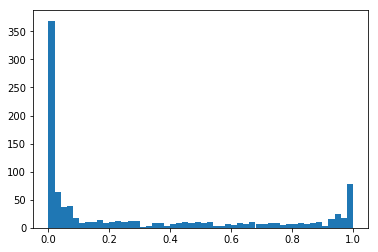

In [521]:
plt.hist([combined_ensemble[k]['data'][0] for k in combined_ensemble.keys()], 50);

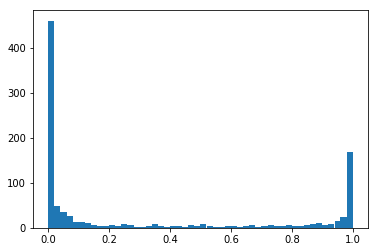

In [288]:
plt.hist([combined_ensemble[k]['data'][0] for k in combined_ensemble.keys()], 50);

In [289]:
# NB_FOLDS = 3
# iou_thresh = .3

# tmp_path = os.path.join(PATHS['TEST'], 'preds', '{}', '{}')
# paths = glob(tmp_path.format('0', '*.npz'))
# paths = [tmp_path.format('{}{}', os.path.basename(path)) for path in paths]

# # ensemble = ensemble_preds(paths, postfix='resnet50_no_clf_last_wd', nb_folds=2)
# # ensemble = ensemble_preds(paths, postfix='50_no_clf_last', nb_folds=1)
# ensemble = ensemble_preds(paths, postfix='retinanet_resnet101_no_clf_last_wd', nb_folds=[2])
# # ensemble = ensemble_preds(paths, postfix='_34_no_clf', nb_folds=1)

In [290]:
ensemble_scores = dict()
for idx, pred in ensemble.items():
    scores = dict()
    for key, data in pred['data'].items():
        scores[key] = data[0, 1] if len(data) else 0
    ensemble_scores[idx] = list(scores.values())

# mean_ = np.mean(ensemble_scores[0])
# std_ = np.std(ensemble_scores[0])
# for idx, pred in ensemble.items():
#     for key, _ in pred['data'].items():
#         data = ensemble[idx]['data'][key]
#         mean = np.mean(ensemble_scores[idx])
#         std = np.std(ensemble_scores[idx])
#         data[:, 1] = (((data[:, 1] - mean) / std) * std_ + mean_)
#         data[:, 1] = np.clip(data[:, 1], 0, 1)
#         ensemble[idx]['data'][key] = data

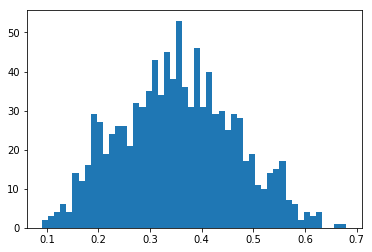

In [291]:
plt.hist(scores.values(), 50);

## TRY TO SELECT BBX PROPERLY, NOT JUST $[:1]$

In [462]:
# tmp_path = os.path.join(PATHS['TEST'], 'preds', '{}', '{}')
# paths = glob(tmp_path.format('0', '*.npz'))
# paths = [tmp_path.format('{}', os.path.basename(path)) for path in paths]

# combined = dict()
# for path in tqdm(paths):
#     clfs = 0
#     for fold in range(NB_FOLDS):
#         clfs += np.load(path.format(fold))['clfs']
#     combined[os.path.basename(path)] = softmax(clfs / 4)[1]

In [463]:
def merge_all_boxes_for_image(boxes, intersection_thr=0.55, type='avg'):

    new_boxes = boxes[0].copy()
    init_weight = 1/len(boxes)
    weights = [init_weight] * len(new_boxes)
    visited = np.ones((len(boxes),))
    visited[0] = 0
    while visited.sum():
        for j in np.where(visited)[0]:
            if not len(boxes[j]):
                visited[j] = 0
                continue
            current_bbx = boxes[j].pop()
            index, best_iou = zft_nms.find_matching_box(new_boxes, current_bbx, intersection_thr)
            if index != -1:
                new_boxes[index] = zft_nms.merge_boxes_weighted(new_boxes[index], current_bbx, weights[index], init_weight, type)
                weights[index] += init_weight
            else:
                new_boxes.append(current_bbx)
                weights.append(init_weight)

    for i in range(len(new_boxes)):
        new_boxes[i][1] *= weights[i]
    return np.array(new_boxes)


In [485]:
keys = ensemble[list(ensemble.keys())[0]]['data'].keys()

merged = dict()
for key in tqdm(keys):
    bboxes = list()
    for _, patients in ensemble.items():
        bboxes.append(patients['data'][key].tolist())
    bboxes = zft_nms.merge_all_boxes_for_image(bboxes, intersection_thr=.4, type='mul')
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes = np.array(bboxes)
    merged[key] = bboxes


100%|██████████| 1000/1000 [00:00<00:00, 1833.28it/s]


In [486]:
scores = dict()
for key, data in merged.items():
    scores[key] = data[0, 1] if len(data) else 0

coeff = .35
coeff = sorted(scores.values(), reverse=True)[int(len(scores) * coeff)]
print(coeff)

0.39865711782528945


In [487]:
combined = pickle.load(open('../data/csv/combined.pkl', 'rb'))
old_combined = pickle.load(open('../data/csv/combined.pkl', 'rb'))

In [488]:
# combined = {k: combined_ensemble[k]['data'][0] for k in combined_ensemble.keys()}

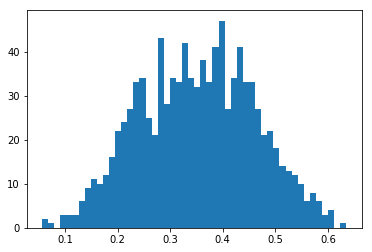

In [489]:
bins = plt.hist(scores.values(), 50)
csm = np.cumsum(bins[0])
# print(csm)
# bins[1][np.where((csm > (370. - 50)) & (csm < (370. + 50)))[0] + 1], csm[np.where((csm > (370. - 50)) & (csm < (370. + 50)))[0] + 1]

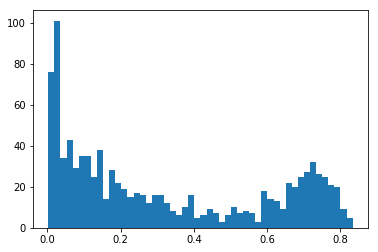

In [490]:
combined1 = {
    k: ((v ** 3) * (scores[k] ** 2)) ** (1/5)
    for k, v in old_combined.items()
}

cbins = plt.hist(combined1.values(), 50)
# np.cumsum(cbins[0][::-1]), cbins[1]

In [491]:
combined_upper = .8

# for key in combined.keys():|

missed_keys = np.array(list(combined.keys()))
missed_keys = missed_keys[[(combined[key] > combined_upper) and (merged[key][0, 1] < coeff) for key in missed_keys]]
print('missed_keys: {}'.format(missed_keys.shape[0]))

missed_keys: 33


diff_keys length: 15


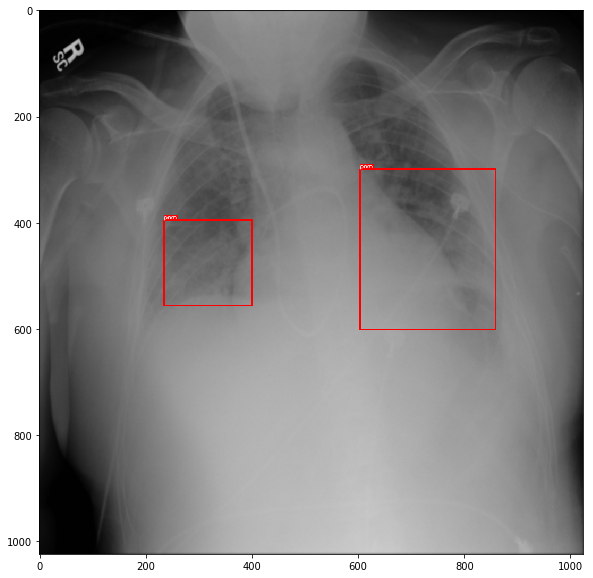

(0.8857, array([0.37650429, 0.2183712 , 0.1523501 , 0.13432359, 0.11328667,
        0.0257689 , 0.01633301, 0.01132813, 0.01057129, 0.00977173]))

In [492]:
new_upper = .9
diff_keys = np.array(list(combined.keys()))
diff_keys = diff_keys[[(combined[key] < new_upper) and (combined[key] > combined_upper) and (merged[key][0, 1] < coeff) for key in diff_keys]]
print('diff_keys length: {}'.format(len(diff_keys)))

key = diff_keys[np.random.randint(len(diff_keys))]
img = cv2.imread(os.path.join(PATHS['TEST'], 'png', key[:-4] + '.dcm.png'))
img = cv2.resize(img, (1024, 1024))
visualize_bboxes(img, merged[key][:2, 2:].astype(np.int))
combined[key], merged[key][:, 1]

0.0455


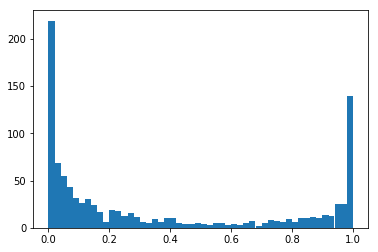

In [493]:
combined_coeff = .3
cthresh = sorted(combined.values())[int(len(combined) * combined_coeff)]
print(cthresh)
# cthresh = max([c for c in cbins[1] if c <= cthresh])
# print(cthresh)
plt.hist(combined.values(), 50);

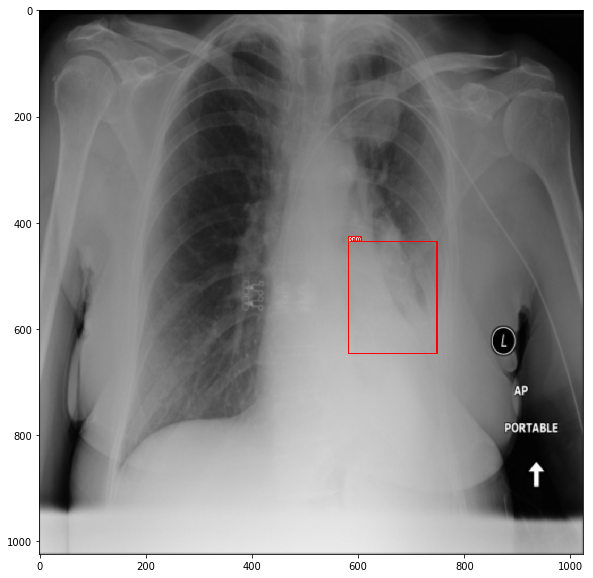

100%|██████████| 1000/1000 [00:02<00:00, 404.28it/s]


In [494]:
df = pd.DataFrame(columns=['patientId', 'PredictionString'])

counter = 0
max_amoun = [[0, 0, None]]
for key, data in tqdm(merged.items()):
    if combined[key] <= combined_upper:
        data = data[data[:, 1] > coeff]
    else:
        idx1 = len(data[data[:, 1] > coeff])
        idx2 = 1 if data[0, 1] > data[1, 1] * 2 else 2

        idx = max([idx1, idx2])
        if map_iou.iou(data[0, 2:], data[1, 2:]) > .4:
            idx = 1

        data = data[:idx]
        
    if len(data) and (combined[key] > cthresh):
        data[:, 4] -= data[:, 2]
        data[:, 5] -= data[:, 3]

#-------------------------------------------------
        if max_amoun[0][0] == len(data):
            max_amoun += [[len(data), key, data]]
        if max_amoun[0][0] < len(data):
            max_amoun = [[len(data), key, data]]
#-------------------------------------------------

        prediction_string = construct_str(data[:, 2:].astype(np.int), data[:, 1])
    else:
        prediction_string = ''
    df = df.append({'patientId': key[:-4], 'PredictionString': prediction_string}, ignore_index=True)
        
    if len(prediction_string):
        counter += 1
        if counter % 100 == 0:
            clear_output(wait=True)
            bbox = data.copy()
            bbox[:, 4] += bbox[:, 2]
            bbox[:, 5] += bbox[:, 3]

            img = cv2.imread(os.path.join(PATHS['TEST'], 'png', key[:-4] + '.dcm.png'))
            img = cv2.resize(img, (1024, 1024))
            visualize_bboxes(img, bbox[:, 2:].astype(np.int))
    

max_amoun len: 246


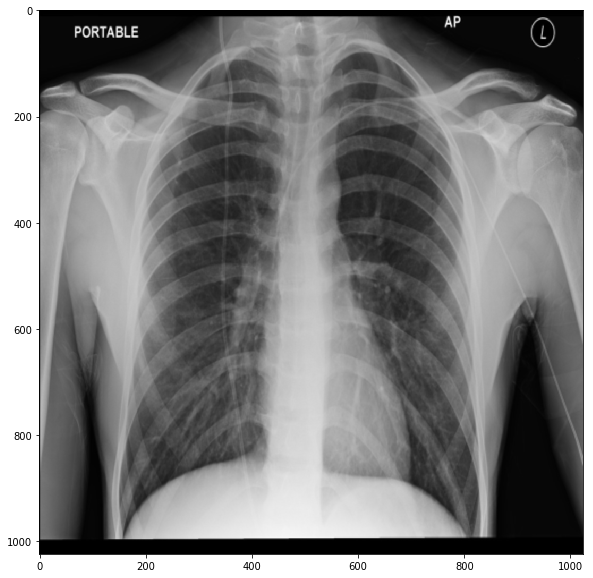

array([], dtype=float64)

In [495]:
print('max_amoun len: {}'.format(len(max_amoun)))
idx = 0
# key = max_amoun[idx][1]
# data = max_amoun[idx][-1].copy()
data[:, 4] += data[:, 2]
data[:, 5] += data[:, 3]
img = cv2.imread(os.path.join(PATHS['TEST'], 'png', key[:-4] + '.dcm.png'))
img = cv2.resize(img, (1024, 1024))
visualize_bboxes(img, data[:, 2:].astype(np.int))
data[:, 1]

max_amoun len: 246


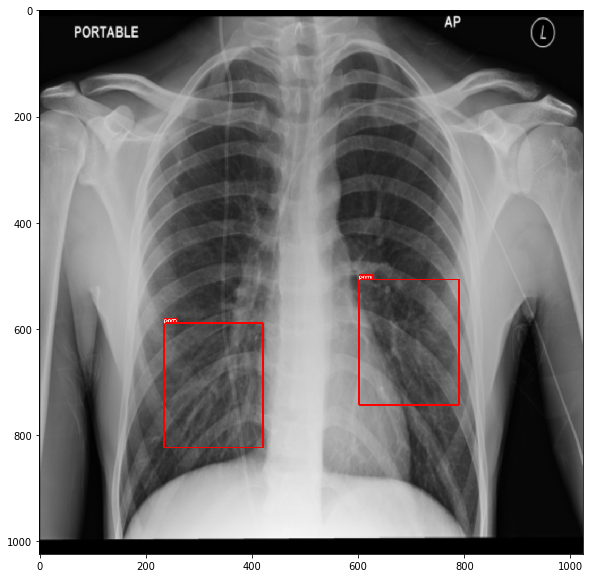

array([0.21032715, 0.10742188])

In [496]:
print('max_amoun len: {}'.format(len(max_amoun)))
idx = 0
data = ensemble[0]['data'][key]
# data[:, 4] += data[:, 2]
# data[:, 5] += data[:, 3]
img = cv2.imread(os.path.join(PATHS['TEST'], 'png', key[:-4] + '.dcm.png'))
img = cv2.resize(img, (1024, 1024))
visualize_bboxes(img, data[:, 2:].astype(np.int))
data[:, 1]

In [497]:
# ldf.PredictionString = ldf.PredictionString.apply(lambda x: x + ' ' if x else x) + rdf.PredictionString

In [498]:
df.to_csv('not_simple_submission.csv', index=False)
df_last = pd.read_csv('not_simple_submission.csv')
df_last.dropna().shape

(377, 2)

In [499]:
df_old = pd.read_csv('not_simple_submission_old.csv')
df_old.dropna().shape

(377, 2)

In [500]:
df_tmp = pd.read_csv('../data/csv/stage_2_train_labels.csv')
df_tmp = df_tmp[df_tmp.patientId.apply(lambda x: x in df_last.patientId.values)]
df_true = pd.DataFrame(columns=['patientId', 'PredictionString'])

for key in tqdm(df_tmp.patientId.unique()):
    data = df_tmp.query('patientId==@key')[['x', 'y', 'width', 'height']].values
    prediction_string = ''
    if not np.isnan(data).sum():
        prediction_string = construct_str(data.astype(np.int), [1] * len(data))
    df_true = df_true.append({'patientId': key, 'PredictionString': prediction_string}, ignore_index=True)

df_true.to_csv('true.csv', index=False)
df_true = pd.read_csv('true.csv')
df_true.dropna().shape

100%|██████████| 1000/1000 [00:03<00:00, 325.80it/s]


(353, 2)

In [501]:
def bbx_from_df(df, key):
    row = df.query('patientId==@key').PredictionString.values[0]
    row = row.split(' ') if isinstance(row, str) else []
    if len(row) and (''.join(row[-1:]) == ''):
        row = row[:-1]
    bbx = np.array(row).astype(np.float).reshape(-1, 5)
    bbx[:, 3] += bbx[:, 1]
    bbx[:, 4] += bbx[:, 2]
    return bbx

In [502]:
scores_true = dict()
for key in tqdm(df_last.patientId):
    bbx1 = bbx_from_df(df_last, key)
    bbx2 = bbx_from_df(df_true, key)
    score = map_iou.map_iou(bbx2[:, 1:], bbx1[:, 1:], bbx1[:, 1])
    scores_true[key] = score


100%|██████████| 1000/1000 [00:02<00:00, 409.40it/s]


In [503]:
scs = {k: v for k, v in scores_true.items() if v is not None}
braced_keys = [k for k, v in scs.items() if v == 0]
sum(scs.values()) / len(scs), len(scs), sum(scs.values()), len(braced_keys)

(0.2031800660792952, 454, 92.24375000000002, 228)

In [396]:
scores_true = dict()
for key in tqdm(df_old.patientId):
    bbx1 = bbx_from_df(df_old, key)
    bbx2 = bbx_from_df(df_true, key)
    score = map_iou.map_iou(bbx2[:, 1:], bbx1[:, 1:], bbx1[:, 1])
    scores_true[key] = score


100%|██████████| 1000/1000 [00:02<00:00, 387.01it/s]


In [397]:
scs = {k: v for k, v in scores_true.items() if v is not None}
braced_keys = [k for k, v in scs.items() if v == 0]
sum(scs.values()) / len(scs), len(scs), sum(scs.values()), len(braced_keys)

(0.2031800660792952, 454, 92.24375000000002, 228)

In [1377]:
scores = dict()
for key in tqdm(df_last.patientId):
    bbx1 = bbx_from_df(df_last, key)
    bbx2 = bbx_from_df(df_old, key)
    score = map_iou.map_iou(bbx2[:, 1:], bbx1[:, 1:], bbx1[:, 1])
    scores[key] = score


100%|██████████| 1000/1000 [00:02<00:00, 392.03it/s]


In [1378]:
scs = {k: v for k, v in scores.items() if v is not None}
braced_keys = [k for k, v in scs.items() if v == 0]
sum(scs.values()) / len(scs), len(scs), sum(scs.values()), len(braced_keys)

(1.0, 377, 377.0, 0)

In [1379]:
def xywh_to_xyxy(bbx, copy=True):
    if copy:
        bbx = bbx.copy()
    bbx[:, 2] += bbx[:, 0]
    bbx[:, 3] += bbx[:, 1]
    return bbx

In [1380]:
i = 0

In [1253]:
map_iou.iou(bbx1[0, 1:], bbx1[1, 1:])

IndexError: index 0 is out of bounds for axis 0 with size 0

0.6504 0.36542390127772156 0


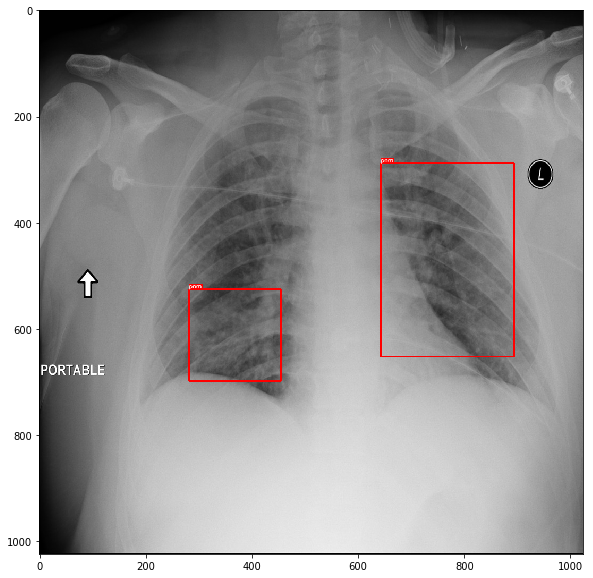

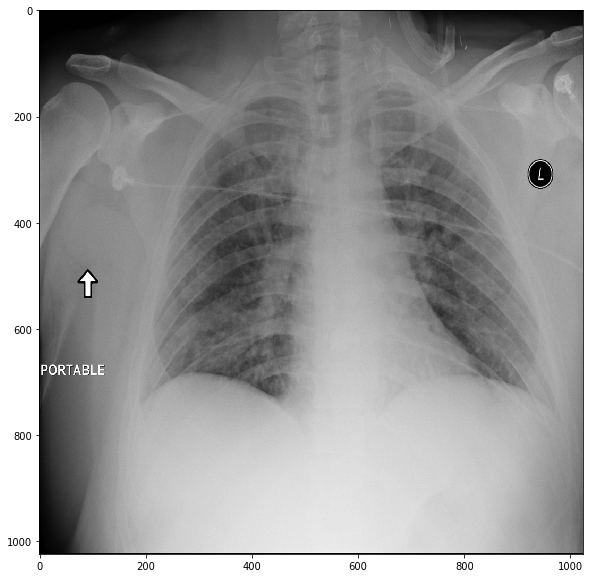

In [1266]:
key = braced_keys[i]

bbx1 = bbx_from_df(df_last, key)
bbx2 = bbx_from_df(df_old, key)
bbx1[:, 1:] = xywh_to_xyxy(bbx1[:, 1:])
bbx2[:, 1:] = xywh_to_xyxy(bbx2[:, 1:])

print(combined[key + '.npz'], bbx1[0, 0] if len(bbx1) else 0, bbx2[0, 0] if len(bbx2) else 0)
img = cv2.imread(os.path.join(PATHS['TEST'], 'png', key + '.dcm.png'))
img = cv2.resize(img, (1024, 1024))

visualize_bboxes(img.copy(), bbx1[:, 1:].astype(np.int))
visualize_bboxes(img.copy(), bbx2[:, 1:].astype(np.int))

i += 1